        Age  Annual Income (k$)  Spending Score (1-100)  Gender
0 -1.424569           -1.738999               -0.434801       1
1 -1.281035           -1.738999                1.195704       1
2 -1.352802           -1.700830               -1.715913      -1
3 -1.137502           -1.700830                1.040418      -1
4 -0.563369           -1.662660               -0.395980      -1


Text(0, 0.5, 'Silhouette Score')

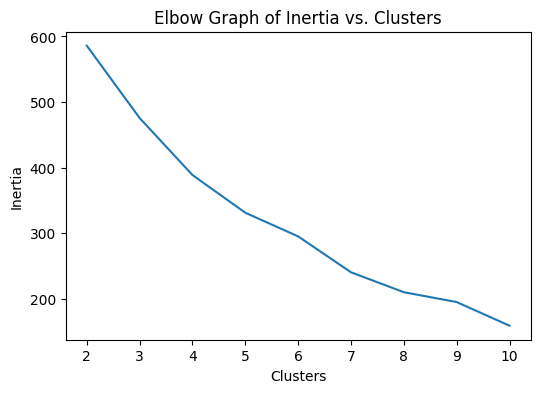

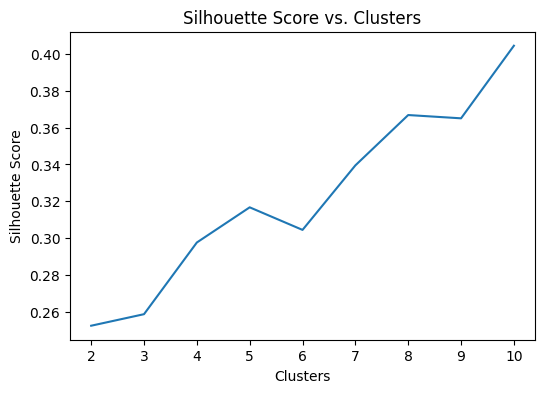

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

FILE = "Mall_Customers.csv"

df_raw = pd.read_csv(FILE)
df_raw = df_raw.drop('CustomerID', axis=1)

scale_cols = df_raw.columns.to_list()
scale_cols.remove('Gender')
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df = pd.DataFrame(scaler.fit_transform(df_raw[scale_cols].to_numpy()), columns=scale_cols)
df['Gender'] = df_raw['Gender'].apply(lambda x: 1 if (x=='Male') else -1)
print(df.head(5))

inertia_vals = {}
silhouette_scores = {}
for n in range(2,11):
    km = KMeans(n_clusters=n, random_state=0).fit(df)
    inertia_vals[n] = km.inertia_
    silhouette_scores[n] = silhouette_score(df, km.labels_)

fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(inertia_vals.keys(), inertia_vals.values())
plt.title('Elbow Graph of Inertia vs. Clusters')
plt.xlabel('Clusters')
plt.ylabel('Inertia')
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(silhouette_scores.keys(), silhouette_scores.values())
plt.title('Silhouette Score vs. Clusters')
plt.xlabel('Clusters')
plt.ylabel('Silhouette Score')


<Axes: xlabel='Annual Income (k$)', ylabel='Spending Score (1-100)'>

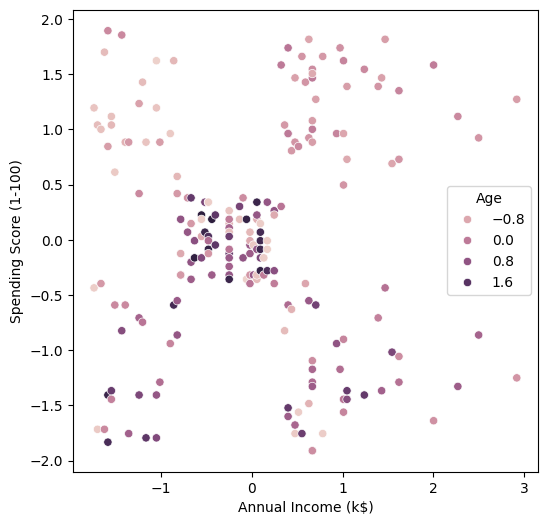

In [2]:
''' From the elbow graph, it looks like 6 clusters gives the best results.
'''

fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(x=df['Annual Income (k$)'], y=df['Spending Score (1-100)'], hue=df['Age'])

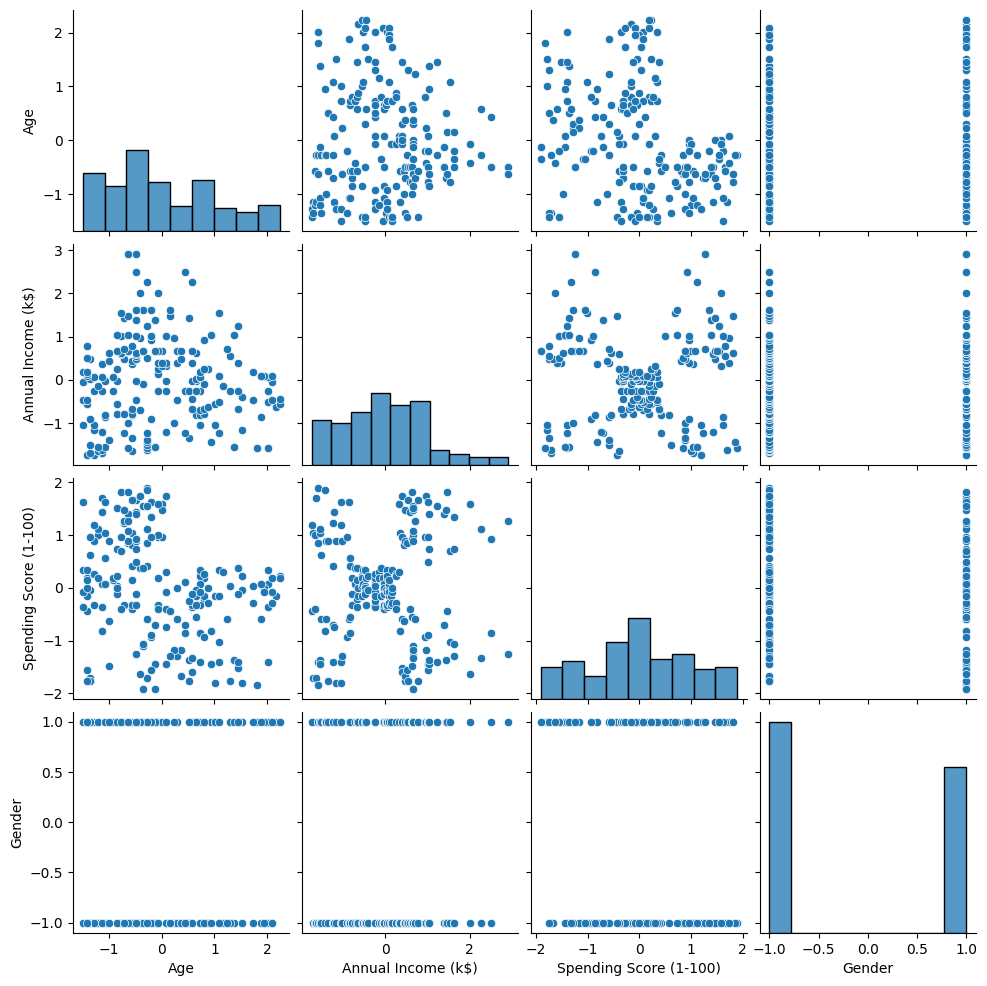

In [3]:
''' From the scatterplot coloured by Age, we can see that older people tend to spend less,
and all the people with high spending score are young (20-40). This plot makes it believable
that we have 6 clusters in the full feature space, even though only 5 are easily visible in the
spending score vs. annual income 2D scatter plots.
'''

sns.pairplot(df)

In [4]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

silhouette_scores = {}
db_scores = {}
ch_scores = {}
eps_vals = np.arange(11,13,0.01)
min_pts = 6
max_silhouette = 0
best_eps = 0
for eps in eps_vals:
    dbscan = DBSCAN(eps=eps, min_samples=min_pts).fit(df)
    s_score = silhouette_score(df, dbscan.labels_)
    silhouette_scores[eps] = s_score
    if s_score > max_silhouette:
        max_silhouette, best_eps = s_score, eps
    db_scores[eps] = davies_bouldin_score(df, dbscan.labels_)
    ch_scores[eps] = calinski_harabasz_score(df, dbscan.labels_)

print("Max silhouette score %f with eps=%f"%(max_silhouette, best_eps))
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(silhouette_scores.keys(), silhouette_scores.values())
plt.title('DBSCAN Silhouette Score vs. Epsilon, min_samples=%d'%min_pts)
plt.xlabel('Epsilon')
plt.ylabel('Silhouette Score')

fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(db_scores.keys(), db_scores.values())
plt.title('DBSCAN Davies-Bouldin Score vs. Epsilon, min_samples=%d'%min_pts)
plt.xlabel('Epsilon')
plt.ylabel('Davies-Bouldin Score')

fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(ch_scores.keys(), ch_scores.values())
plt.title('DBSCAN Calinski-Harabasz Score vs. Epsilon, min_samples=%d'%min_pts)
plt.xlabel('Epsilon')
plt.ylabel('Calinski-Harabasz Score')

dbscan = DBSCAN(eps=best_eps, min_samples=min_pts).fit(df)
unique_vals, counts = np.unique(dbscan.labels_, return_counts=True)
for val, count in zip(unique_vals, counts):
    print("Value %d occurs %d times"%(val, count))

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [ ]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(df)
col_labels = ['silhouette score', 'davies-bouldin score', 'calinski-harabasz score']
km_scores = [silhouette_score(df, kmeans.labels_), davies_bouldin_score(df, kmeans.labels_), calinski_harabasz_score(df, kmeans.labels_)]
db_scores = [silhouette_score(df, dbscan.labels_), davies_bouldin_score(df, dbscan.labels_), calinski_harabasz_score(df, dbscan.labels_)]
km_row = {'algorithm': 'kmeans'}
db_row = {'algorithm': 'dbscan'}
for n in range(len(col_labels)):
    km_row[col_labels[n]] = km_scores[n]
    db_row[col_labels[n]] = db_scores[n]

scores_df = pd.DataFrame([km_row, db_row])
print(scores_df)


  algorithm  silhouette score  davies-bouldin score  calinski-harabasz score
0    kmeans          0.450951              0.751533               166.585711
1    dbscan          0.230724              1.990005                35.652794
